## Dog breed competition with only the pretrained models from imagenet

<font color='blue'>This post describe the method and tips I got from participanting in the Dog Breed challenge[Dog Breed challenge] in Kaggle. I managed to get an final score of 0.13783, which sets me in the 158 postion, considering a lot of competitors are leveraging the 3-rd party dataset(which already contain the test data), I believe my approach worth sharing cause there is nothing else being used except the pretrained imagenet models.(However, there are a ensembles :O)</font>
[Dog Breed challenge]: http://www.kaggle.com/c/dog-breed-identification

In [9]:
import os
os.chdir('D:\Machine Learning\Kaggle\Dog Breed Identification\pytorch')

<font color='blue'>I delve into this problem firtsly using keras. However I cannot find powerful pretrained models like nasnet in Keras. Then I found this awesome package of [Pytorch pretrained models], all the models I have tryed are actually coming from this package.</font>
[Pytorch pretrained models]: http://github.com/Cadene/pretrained-models.pytorch

In [47]:
from PIL import  Image
import torch
from torch.utils.data import Dataset,DataLoader,TensorDataset,ConcatDataset
from torchvision import transforms as trans
from torchvision import models,utils
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tqdm import tqdm
import pretrainedmodels
from torch import nn
from torch import optim
from torch.autograd import Variable

<font color='blue'>A dog image reading class is created using Pytorch Dataset. Please refer to the file for detail.</font>

In [11]:
from dataset.dataset import Dogs

<font color='blue'>Setting all the hyperparameters,you can set *batch_size* larger if you have enough GPU memory</font>

In [34]:
work_folder = Path('D:\Machine Learning\Kaggle\Dog Breed Identification')
train_image_folder = work_folder/'train'
test_image_folder = work_folder/'test'
bottlenecks_folder = work_folder/'pytorch'/'bottlenecks'
pred_folder = work_folder/'pred'
df_train = pd.read_csv(work_folder/'labels.csv',index_col=0)
df_test = pd.read_csv(work_folder/'sample_submission.csv',index_col=0)
img_size = 331
batch_size = 4
batch_size_top = 4096
use_cuda = torch.cuda.is_available()
date = '0222'
model_name = 'nasnet'
learning_rate = 0.0001
dropout_ratio = 0.5
input_shape = 331
crop_mode = 'center'
use_bias = True
name = '{}__model={}__lr={}__input_shape={}__drop={}__crop_mode={}__bias={}'.format(date,model_name,learning_rate,input_shape,dropout_ratio,crop_mode,use_bias)

<font color='blue'>I found out there 2 ways to preprocess the diffrent size image into same shape, resize and center cropping. The diffrence is subtle between them, hence it become part of hyperparameters, following transforms is tested for image preprocessing, however, after several checks I can say center cropping can gain a better result than resize.It looks like at least in this dataset it's better to keep the original image height and width ratio than keep the image margin.</font>

In [35]:
if crop_mode == 'center':
    transforms = trans.Compose([
        trans.Resize(input_shape),
        trans.CenterCrop(input_shape),
        trans.ToTensor(),
        trans.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])
elif crop_mode == 'resize':
    transforms = trans.Compose([
        trans.Resize((input_shape,input_shape)),
        trans.ToTensor(),
        trans.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])

<font color='blue'>Create the corresponding datasets and dataloader</font>

In [36]:
train_dataset = Dogs(train_image_folder,df_train,df_test,is_train=True,resize=False,transforms=transforms)
test_dataset = Dogs(test_image_folder,df_train,df_test,False,resize=False,transforms=transforms)
train_dataset_resize = Dogs(train_image_folder,df_train,df_test,is_train=True,resize=True,transforms=transforms)

train_loader = DataLoader(train_dataset,batch_size,num_workers=0,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size,num_workers=0,shuffle=False)

<font color='blue'>We can see the diffrence between center crop and resize here</font>

In [37]:
img_center_crop = train_dataset.__getitem__(0)[0]*0.5 + 0.5

transforms_resize = trans.Compose([
        trans.Resize((input_shape,input_shape)),
        trans.ToTensor(),
        trans.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])

train_dataset_resize = Dogs(train_image_folder,df_train,df_test,is_train=True,resize=False,transforms=transforms_resize)

img_resize = train_dataset_resize.__getitem__(0)[0]*0.5 + 0.5

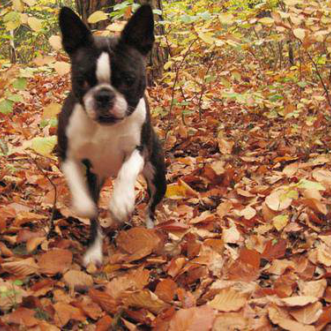

In [41]:
trans.ToPILImage()(img_center_crop)

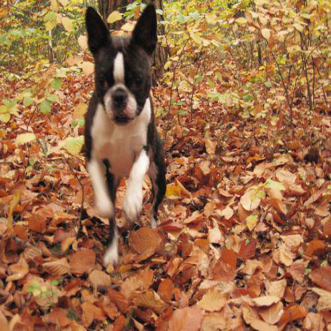

In [42]:
trans.ToPILImage()(img_resize)

<font color='blue'>The key to transfer learning is to get the bottleneck outputs.Normally we are using the second last layer before the final softmax classifier.</font> 
<font color='blue'><br>For *__nasnet__* in the predefined model,we can simply realize this by changing the last 2 layers of the original model into an identity mapping.</font> 

In [8]:
def get_extraction_model():
    nasnet = pretrainedmodels.nasnetalarge(num_classes=1000)
    nasnet = nasnet.eval()
    nasnet.avg_pool = nn.AdaptiveAvgPool2d(1)
    del nasnet.dropout
    del nasnet.last_linear
    nasnet.dropout = lambda x:x
    nasnet.last_linear = lambda x:x
    return nasnet

In [9]:
extraction_nasnet = get_extraction_model()

if use_cuda:
    extraction_nasnet.cuda()

<font color='blue'>function to get the bottleneck output, notice that we keep the dataloader not shuffled so the output is sequential </font> 

In [11]:
def get_bottlenecks(data_loader,extration_model,test_mode=False):
    x_pieces = []
    y_pieces = []
    for x,y in tqdm(iter(data_loader)):
        if use_cuda:
            x = Variable(x)
            y = Variable(y) if not test_mode else y
            x = x.cuda()
            y = y.cuda() if not test_mode else y
        x_pieces.append(extration_model(x).cpu().data.numpy())
        y_pieces.append(y.cpu().data.numpy()) if not test_mode else y_pieces
    bottlenecks_x = np.concatenate(x_pieces)
    bottlenecks_y = np.concatenate(y_pieces) if not test_mode else None
    return bottlenecks_x,bottlenecks_y

In [12]:
bottlenecks_x,bottlenecks_y= get_bottlenecks(train_loader,extraction_nasnet)

In [13]:
# np.save(bottlenecks_folder/(name+'_x'),bottlenecks_x)
# np.save(bottlenecks_folder/(name+'_y'),bottlenecks_y)

# bottlenecks_x = np.load(bottlenecks_folder/(name + '_x.npy'))
# bottlenecks_y = np.load(bottlenecks_folder/(name + '_y.npy'))

<font color='blue'>delete the model to save GPU memory</font> 

In [15]:
del extraction_nasnet

<font color='blue'>Create the linear layer whose input is the bottleneck features, output is the 120 classes.</font> 

In [17]:
class TopModule(nn.Module):
    def __init__(self,dropout_ratio):
        super(TopModule, self).__init__()
        self.aff = nn.Linear(4032, 120,bias=use_bias)
        self.dropout_ratio = dropout_ratio
    def forward(self,x):
        x = nn.Dropout(p = dropout_ratio)(x)
        x = self.aff(x)
        return x

In [18]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()

<font color='blue'>train and validation data split</font> 

In [19]:
permutation = np.random.permutation(bottlenecks_x.shape[0])

x_train = bottlenecks_x[permutation][:-int(bottlenecks_x.shape[0]//5)]
x_val = bottlenecks_x[permutation][-int(bottlenecks_x.shape[0]//5):]
y_train = bottlenecks_y[permutation][:-int(bottlenecks_y.shape[0]//5)]
y_val = bottlenecks_y[permutation][-int(bottlenecks_y.shape[0]//5):]

top_only_train_dataset = TensorDataset(torch.FloatTensor(x_train),torch.LongTensor(y_train))

top_only_val_dataset = TensorDataset(torch.FloatTensor(x_val),torch.LongTensor(y_val))

top_only_train_loader = DataLoader(top_only_train_dataset,batch_size=batch_size_top,shuffle=True)
top_only_val_loader = DataLoader(top_only_val_dataset,batch_size=batch_size_top,shuffle=True)

total_dataset = ConcatDataset([top_only_train_dataset,top_only_val_dataset])
total_loader = DataLoader(total_dataset,batch_size=batch_size_top,shuffle=True)

<font color='blue'>training function.</font> 

In [42]:
def fit(loader,optimizer,criterion,model=top_only_model,epochs=1500,evaluate=True):
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs):  
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
        
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
        
            optimizer.zero_grad()
        
            # forward + backward 
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()   
        
            optimizer.step()
        
        running_loss += loss.data[0]
    
        print('[%d, %5d] Train_loss: %.3f' \% (epoch+1, i+1, running_loss / len(loader)))
    
        if evaluate:
            model.eval()
            outputs = model(Variable(torch.from_numpy(x_val),volatile=True).cuda() if use_cuda else Variable(torch.from_numpy(x_val),volatile=True))
            labels = torch.from_numpy(y_val).cuda() if use_cuda else torch.from_numpy(y_val)
            labels = Variable(labels,volatile=True)
            loss = criterion(outputs,labels)
            x_val_v = Variable(torch.FloatTensor(x_val),volatile=True).cuda() if use_cuda else Variable(torch.FloatTensor(x_val),volatile=True)
            _,pred = torch.max(model(x_val_v),1)
            val_acc = np.mean(pred.cpu().data.numpy() == labels.cpu().data.numpy())
            val_loss_history.append(loss.cpu().data.numpy())
            val_acc_history.append(val_acc)
    
            print('[%d] Val_loss: %.3f'% (epoch+1, loss))
            print('[%d] Val_acc: %.3f'% (epoch+1, val_acc))
            model.train()
    
    print('Finished Training')
    return val_loss_history,val_acc_history 

In [ ]:
val_loss_history,val_acc_history = fit(top_only_train_loader,optimizer,criterion,top_only_model,epochs=1500,evaluate=True)

[1,     2] Train_loss: 2.384
[1] Val_loss: 4.732
[1] Val_acc: 0.019
[2,     2] Train_loss: 2.349
[2] Val_loss: 4.677
[2] Val_acc: 0.046
[3,     2] Train_loss: 2.318
[3] Val_loss: 4.610
[3] Val_acc: 0.094
[4,     2] Train_loss: 2.288
[4] Val_loss: 4.547
[4] Val_acc: 0.171
[5,     2] Train_loss: 2.258
[5] Val_loss: 4.487
[5] Val_acc: 0.271
[6,     2] Train_loss: 2.227
[6] Val_loss: 4.429
[6] Val_acc: 0.382
[7,     2] Train_loss: 2.197
[7] Val_loss: 4.368
[7] Val_acc: 0.500
[8,     2] Train_loss: 2.165
[8] Val_loss: 4.309
[8] Val_acc: 0.604
[9,     2] Train_loss: 2.135
[9] Val_loss: 4.244
[9] Val_acc: 0.693
[10,     2] Train_loss: 2.102
[10] Val_loss: 4.186
[10] Val_acc: 0.751
[11,     2] Train_loss: 2.075
[11] Val_loss: 4.130
[11] Val_acc: 0.803
[12,     2] Train_loss: 2.043
[12] Val_loss: 4.073
[12] Val_acc: 0.823
[13,     2] Train_loss: 2.013
[13] Val_loss: 4.006
[13] Val_acc: 0.851
[14,     2] Train_loss: 1.983
[14] Val_loss: 3.948
[14] Val_acc: 0.872
[15,     2] Train_loss: 1.952
[15

[226] Val_acc: 0.942
[227,     2] Train_loss: 0.119
[227] Val_loss: 0.277
[227] Val_acc: 0.941
[228,     2] Train_loss: 0.112
[228] Val_loss: 0.273
[228] Val_acc: 0.941
[229,     2] Train_loss: 0.115
[229] Val_loss: 0.270
[229] Val_acc: 0.942
[230,     2] Train_loss: 0.108
[230] Val_loss: 0.269
[230] Val_acc: 0.944
[231,     2] Train_loss: 0.112
[231] Val_loss: 0.270
[231] Val_acc: 0.943
[232,     2] Train_loss: 0.111
[232] Val_loss: 0.269
[232] Val_acc: 0.943
[233,     2] Train_loss: 0.113
[233] Val_loss: 0.272
[233] Val_acc: 0.943
[234,     2] Train_loss: 0.115
[234] Val_loss: 0.269
[234] Val_acc: 0.942
[235,     2] Train_loss: 0.115
[235] Val_loss: 0.268
[235] Val_acc: 0.942
[236,     2] Train_loss: 0.109
[236] Val_loss: 0.266
[236] Val_acc: 0.942
[237,     2] Train_loss: 0.114
[237] Val_loss: 0.266
[237] Val_acc: 0.942
[238,     2] Train_loss: 0.104
[238] Val_loss: 0.263
[238] Val_acc: 0.942
[239,     2] Train_loss: 0.108
[239] Val_loss: 0.265
[239] Val_acc: 0.944
[240,     2] Trai

[448,     2] Train_loss: 0.063
[448] Val_loss: 0.206
[448] Val_acc: 0.944
[449,     2] Train_loss: 0.064
[449] Val_loss: 0.211
[449] Val_acc: 0.940
[450,     2] Train_loss: 0.062
[450] Val_loss: 0.211
[450] Val_acc: 0.941
[451,     2] Train_loss: 0.069
[451] Val_loss: 0.209
[451] Val_acc: 0.946
[452,     2] Train_loss: 0.065
[452] Val_loss: 0.206
[452] Val_acc: 0.942
[453,     2] Train_loss: 0.066
[453] Val_loss: 0.208
[453] Val_acc: 0.942
[454,     2] Train_loss: 0.063
[454] Val_loss: 0.210
[454] Val_acc: 0.942
[455,     2] Train_loss: 0.062
[455] Val_loss: 0.206
[455] Val_acc: 0.942
[456,     2] Train_loss: 0.063
[456] Val_loss: 0.208
[456] Val_acc: 0.940
[457,     2] Train_loss: 0.059
[457] Val_loss: 0.209
[457] Val_acc: 0.941
[458,     2] Train_loss: 0.067
[458] Val_loss: 0.206
[458] Val_acc: 0.941
[459,     2] Train_loss: 0.068
[459] Val_loss: 0.207
[459] Val_acc: 0.942
[460,     2] Train_loss: 0.063
[460] Val_loss: 0.210
[460] Val_acc: 0.942
[461,     2] Train_loss: 0.060
[461] V

[558] Val_acc: 0.943
[559,     2] Train_loss: 0.054
[559] Val_loss: 0.198
[559] Val_acc: 0.941
[560,     2] Train_loss: 0.055
[560] Val_loss: 0.199
[560] Val_acc: 0.942
[561,     2] Train_loss: 0.055
[561] Val_loss: 0.201
[561] Val_acc: 0.943
[562,     2] Train_loss: 0.055
[562] Val_loss: 0.199
[562] Val_acc: 0.940
[563,     2] Train_loss: 0.054
[563] Val_loss: 0.202
[563] Val_acc: 0.941
[564,     2] Train_loss: 0.056
[564] Val_loss: 0.199
[564] Val_acc: 0.940
[565,     2] Train_loss: 0.056
[565] Val_loss: 0.204
[565] Val_acc: 0.939
[566,     2] Train_loss: 0.053
[566] Val_loss: 0.200
[566] Val_acc: 0.943
[567,     2] Train_loss: 0.055
[567] Val_loss: 0.202
[567] Val_acc: 0.946
[568,     2] Train_loss: 0.055
[568] Val_loss: 0.199
[568] Val_acc: 0.943
[569,     2] Train_loss: 0.052
[569] Val_loss: 0.201
[569] Val_acc: 0.942
[570,     2] Train_loss: 0.057
[570] Val_loss: 0.202
[570] Val_acc: 0.942
[571,     2] Train_loss: 0.054
[571] Val_loss: 0.202
[571] Val_acc: 0.942
[572,     2] Trai

[780,     2] Train_loss: 0.045
[780] Val_loss: 0.194
[780] Val_acc: 0.942
[781,     2] Train_loss: 0.040
[781] Val_loss: 0.197
[781] Val_acc: 0.941
[782,     2] Train_loss: 0.040
[782] Val_loss: 0.196
[782] Val_acc: 0.940
[783,     2] Train_loss: 0.039
[783] Val_loss: 0.198
[783] Val_acc: 0.944
[784,     2] Train_loss: 0.041
[784] Val_loss: 0.199
[784] Val_acc: 0.944
[785,     2] Train_loss: 0.040
[785] Val_loss: 0.196
[785] Val_acc: 0.939
[786,     2] Train_loss: 0.039
[786] Val_loss: 0.201
[786] Val_acc: 0.942
[787,     2] Train_loss: 0.039
[787] Val_loss: 0.194
[787] Val_acc: 0.941
[788,     2] Train_loss: 0.040
[788] Val_loss: 0.196
[788] Val_acc: 0.940
[789,     2] Train_loss: 0.040
[789] Val_loss: 0.201
[789] Val_acc: 0.943
[790,     2] Train_loss: 0.042
[790] Val_loss: 0.195
[790] Val_acc: 0.945
[791,     2] Train_loss: 0.039
[791] Val_loss: 0.197
[791] Val_acc: 0.942
[792,     2] Train_loss: 0.041
[792] Val_loss: 0.197
[792] Val_acc: 0.945
[793,     2] Train_loss: 0.042
[793] V

[890] Val_acc: 0.944
[891,     2] Train_loss: 0.036
[891] Val_loss: 0.196
[891] Val_acc: 0.940
[892,     2] Train_loss: 0.039
[892] Val_loss: 0.196
[892] Val_acc: 0.943
[893,     2] Train_loss: 0.037
[893] Val_loss: 0.202
[893] Val_acc: 0.942
[894,     2] Train_loss: 0.037
[894] Val_loss: 0.198
[894] Val_acc: 0.943
[895,     2] Train_loss: 0.035
[895] Val_loss: 0.193
[895] Val_acc: 0.940
[896,     2] Train_loss: 0.037
[896] Val_loss: 0.202
[896] Val_acc: 0.944
[897,     2] Train_loss: 0.034
[897] Val_loss: 0.199
[897] Val_acc: 0.942
[898,     2] Train_loss: 0.036
[898] Val_loss: 0.193
[898] Val_acc: 0.942
[899,     2] Train_loss: 0.036
[899] Val_loss: 0.199
[899] Val_acc: 0.942
[900,     2] Train_loss: 0.034
[900] Val_loss: 0.197
[900] Val_acc: 0.944
[901,     2] Train_loss: 0.034
[901] Val_loss: 0.194
[901] Val_acc: 0.944
[902,     2] Train_loss: 0.033
[902] Val_loss: 0.202
[902] Val_acc: 0.943
[903,     2] Train_loss: 0.034
[903] Val_loss: 0.198
[903] Val_acc: 0.943
[904,     2] Trai

[1107,     2] Train_loss: 0.029
[1107] Val_loss: 0.199
[1107] Val_acc: 0.941
[1108,     2] Train_loss: 0.028
[1108] Val_loss: 0.195
[1108] Val_acc: 0.936
[1109,     2] Train_loss: 0.029
[1109] Val_loss: 0.201
[1109] Val_acc: 0.939
[1110,     2] Train_loss: 0.030
[1110] Val_loss: 0.201
[1110] Val_acc: 0.945
[1111,     2] Train_loss: 0.027
[1111] Val_loss: 0.199
[1111] Val_acc: 0.942
[1112,     2] Train_loss: 0.030
[1112] Val_loss: 0.202
[1112] Val_acc: 0.943
[1113,     2] Train_loss: 0.031
[1113] Val_loss: 0.195
[1113] Val_acc: 0.941
[1114,     2] Train_loss: 0.028
[1114] Val_loss: 0.196
[1114] Val_acc: 0.941
[1115,     2] Train_loss: 0.029
[1115] Val_loss: 0.197
[1115] Val_acc: 0.941
[1116,     2] Train_loss: 0.028
[1116] Val_loss: 0.199
[1116] Val_acc: 0.941
[1117,     2] Train_loss: 0.029
[1117] Val_loss: 0.200
[1117] Val_acc: 0.945
[1118,     2] Train_loss: 0.029
[1118] Val_loss: 0.197
[1118] Val_acc: 0.941
[1119,     2] Train_loss: 0.027
[1119] Val_loss: 0.199
[1119] Val_acc: 0.945

<font color='blue'>get the best_epochs, and use it to train all the data(yes,I 'd like any tiny bit of improvement :)</font> 

In [45]:
best_epochs = np.argmin(np.array(val_loss_history))

In [46]:
best_epochs

863

In [47]:
best_val_loss = min(val_loss_history)

In [48]:
best_val_loss

array([ 0.18992244], dtype=float32)

In [49]:
top_only_model = TopModule(dropout_ratio)
if use_cuda:
    top_only_model = top_only_model.cuda()
optimizer = optim.Adam(top_only_model.parameters(),lr=learning_rate)

In [50]:
fit(total_loader,optimizer,criterion,top_only_model,epochs=best_epochs,evaluate=False)

[1,     3] Train_loss: 1.574
[2,     3] Train_loss: 1.545
[3,     3] Train_loss: 1.512
[4,     3] Train_loss: 1.484
[5,     3] Train_loss: 1.452
[6,     3] Train_loss: 1.424
[7,     3] Train_loss: 1.395
[8,     3] Train_loss: 1.363
[9,     3] Train_loss: 1.334
[10,     3] Train_loss: 1.305
[11,     3] Train_loss: 1.277
[12,     3] Train_loss: 1.244
[13,     3] Train_loss: 1.216
[14,     3] Train_loss: 1.188
[15,     3] Train_loss: 1.161
[16,     3] Train_loss: 1.129
[17,     3] Train_loss: 1.103
[18,     3] Train_loss: 1.077
[19,     3] Train_loss: 1.050
[20,     3] Train_loss: 1.020
[21,     3] Train_loss: 0.994
[22,     3] Train_loss: 0.961
[23,     3] Train_loss: 0.937
[24,     3] Train_loss: 0.911
[25,     3] Train_loss: 0.886
[26,     3] Train_loss: 0.860
[27,     3] Train_loss: 0.831
[28,     3] Train_loss: 0.807
[29,     3] Train_loss: 0.787
[30,     3] Train_loss: 0.759
[31,     3] Train_loss: 0.736
[32,     3] Train_loss: 0.712
[33,     3] Train_loss: 0.690
[34,     3] Train_l

[532,     3] Train_loss: 0.033
[533,     3] Train_loss: 0.031
[534,     3] Train_loss: 0.034
[535,     3] Train_loss: 0.032
[536,     3] Train_loss: 0.033
[537,     3] Train_loss: 0.032
[538,     3] Train_loss: 0.028
[539,     3] Train_loss: 0.032
[540,     3] Train_loss: 0.030
[541,     3] Train_loss: 0.030
[542,     3] Train_loss: 0.030
[543,     3] Train_loss: 0.029
[544,     3] Train_loss: 0.029
[545,     3] Train_loss: 0.031
[546,     3] Train_loss: 0.028
[547,     3] Train_loss: 0.031
[548,     3] Train_loss: 0.027
[549,     3] Train_loss: 0.028
[550,     3] Train_loss: 0.029
[551,     3] Train_loss: 0.033
[552,     3] Train_loss: 0.029
[553,     3] Train_loss: 0.029
[554,     3] Train_loss: 0.030
[555,     3] Train_loss: 0.033
[556,     3] Train_loss: 0.030
[557,     3] Train_loss: 0.028
[558,     3] Train_loss: 0.030
[559,     3] Train_loss: 0.029
[560,     3] Train_loss: 0.031
[561,     3] Train_loss: 0.028
[562,     3] Train_loss: 0.035
[563,     3] Train_loss: 0.029
[564,   

([], [])

In [51]:
extraction_nasnet = get_extraction_model()

if use_cuda:
    extraction_nasnet.cuda()

<font color='blue'>get the test bottleneck features.</font> 

In [52]:
bottlenecks_test_x,test_y = get_bottlenecks(test_loader,extraction_nasnet,True)

100%|██████████████████████████████████████████████████████████████████████████████| 2590/2590 [05:09<00:00,  8.38it/s]


In [53]:
np.save(bottlenecks_folder/(name+'_test_x'),bottlenecks_test_x)

In [55]:
del extraction_nasnet

<font color='blue'>remember to switch the top model to eval mode, cause it used dropout</font> 

In [56]:
top_only_model.eval()

TopModule(
  (aff): Linear(in_features=4032, out_features=120)
)

<font color='blue'>generate the final prediction.</font> 

In [57]:
x_test = Variable(torch.FloatTensor(bottlenecks_test_x),volatile=True).cuda() if use_cuda else Variable(torch.FloatTensor(bottlenecks_test_x),volatile=True)

In [58]:
pred_np = (nn.Softmax(1)(top_only_model(x_test))).cpu().data.numpy()

In [59]:
df_pred = pd.DataFrame(pred_np,index=df_test.index,columns=df_test.columns)

In [60]:
df_pred.to_csv(pred_folder/(name+'.csv'))

- <font color='blue'>By simply using nasnet pretrained model, I got a score of 0.157.</font> 
- <font color='blue'>Final score of 0.137 is achieved through [psuedo labeling] and ensemble with results from other models.</font> 

## <font color='blue'>some tips I got:</font> 
- <font color='blue'>center cropping is better than resize</font> 
- <font color='blue'>I tried data augmentation, which is not helping, I think this is because there is already a lot of dog pictures of diffrent dog species in the imagenet, hence the model already learned enough feature format in the upper layer</font> 
- <font color='blue'>I tried *nasnet*,*inceptionv4*,*inceptionresnetv2*,*dpn107*,*xception*,*resnet152*,*inceptionv3* and some other models, the comparison of their performance in this task is identical to their result in the imagenet. Hence, I guess better model in imagenet can get better transfer learning performance, at least in here, fair enough</font>
- <font color='blue'>I also tried to bind the bottleneck features from diffrent models together and train a linear classifier on it,it works, and helped as an important ensemble portion.</font> 

## <font color='blue'>some other things I should try if got more time:</font> 
- <font color='blue'>found out the classes have the highest error rate, do something about it</font>
- <font color='blue'>more playing with the input resolution, I just used the original imagenet input size, I wonder using clearer picture whether would help</font> 
- <font color='blue'>another round of pseudo labeling</font> 
- <font color='blue'>K fold validation</font> 